In [1]:
import os
import torch
import torch.optim as optim

from tqdm import tqdm

from architectures.bigger_basic import BoundingBoxModel
from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.losses import CIoULoss
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json"),
    prefetch_factor=16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
cuda


In [11]:
model = BoundingBoxModel().to(device)
criterion = CIoULoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
epochs_used = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()

            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    epochs_used += 1

    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss, 
        model, 
        path=os.path.join("checkpoints", "checkpoint_3_bigger_basic_ciou.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 227/227 [00:14<00:00, 16.07it/s, Train Loss=0.598]


Epoch 1, Loss: 0.598440486560309


Epoch 1/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.52it/s, Val Loss=0.42] 


Validation Loss: 0.4202861951311254
Validation loss decreased (inf --> 0.420286).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.35it/s, Train Loss=0.379]


Epoch 2, Loss: 0.3787524780250331


Epoch 2/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.59it/s, Val Loss=0.366]


Validation Loss: 0.3661347660461711
Validation loss decreased (0.420286 --> 0.366135).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.56it/s, Train Loss=0.334]


Epoch 3, Loss: 0.3342201416319162


Epoch 3/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.65it/s, Val Loss=0.312]


Validation Loss: 0.3119668900835357
Validation loss decreased (0.366135 --> 0.311967).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.67it/s, Train Loss=0.306]


Epoch 4, Loss: 0.3064190360024112


Epoch 4/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.57it/s, Val Loss=0.304]


Validation Loss: 0.3044202006729689
Validation loss decreased (0.311967 --> 0.304420).  Saving model ...


Epoch 5/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.55it/s, Train Loss=0.298]


Epoch 5, Loss: 0.29840343041829603


Epoch 5/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.52it/s, Val Loss=0.305]


Validation Loss: 0.3046207126016659
EarlyStopping counter: 1 out of 7


Epoch 6/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.54it/s, Train Loss=0.301]


Epoch 6, Loss: 0.3010012051870119


Epoch 6/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.32it/s, Val Loss=0.292]


Validation Loss: 0.29222213677110126
Validation loss decreased (0.304420 --> 0.292222).  Saving model ...


Epoch 7/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.52it/s, Train Loss=0.294]


Epoch 7, Loss: 0.29399137605917086


Epoch 7/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.50it/s, Val Loss=0.301]


Validation Loss: 0.30144625409846787
EarlyStopping counter: 1 out of 7


Epoch 8/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.56it/s, Train Loss=0.286]


Epoch 8, Loss: 0.28640567928158767


Epoch 8/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.52it/s, Val Loss=0.27] 


Validation Loss: 0.2700270749136215
Validation loss decreased (0.292222 --> 0.270027).  Saving model ...


Epoch 9/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.56it/s, Train Loss=0.283]


Epoch 9, Loss: 0.2825989358882022


Epoch 9/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.14it/s, Val Loss=0.267]


Validation Loss: 0.2669960863002071
Validation loss decreased (0.270027 --> 0.266996).  Saving model ...


Epoch 10/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.36it/s, Train Loss=0.276]


Epoch 10, Loss: 0.2757118238620296


Epoch 10/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.49it/s, Val Loss=0.276]


Validation Loss: 0.27638208321275165
EarlyStopping counter: 1 out of 7


Epoch 11/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.61it/s, Train Loss=0.273]


Epoch 11, Loss: 0.2726379625072563


Epoch 11/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.44it/s, Val Loss=0.263]


Validation Loss: 0.2627685018835614
Validation loss decreased (0.266996 --> 0.262769).  Saving model ...


Epoch 12/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.62it/s, Train Loss=0.268]


Epoch 12, Loss: 0.26848810491057745


Epoch 12/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.58it/s, Val Loss=0.282]


Validation Loss: 0.28230937100979725
EarlyStopping counter: 1 out of 7


Epoch 13/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.46it/s, Train Loss=0.264]


Epoch 13, Loss: 0.26410066109921965


Epoch 13/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.63it/s, Val Loss=0.27] 


Validation Loss: 0.269920788672527
EarlyStopping counter: 2 out of 7


Epoch 14/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.47it/s, Train Loss=0.262]


Epoch 14, Loss: 0.26183792961851615


Epoch 14/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.54it/s, Val Loss=0.316]


Validation Loss: 0.3164078786903541
EarlyStopping counter: 3 out of 7


Epoch 15/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.53it/s, Train Loss=0.272]


Epoch 15, Loss: 0.2718361553116517


Epoch 15/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.50it/s, Val Loss=0.29] 


Validation Loss: 0.2895472604403937
EarlyStopping counter: 4 out of 7


Epoch 16/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.52it/s, Train Loss=0.264]


Epoch 16, Loss: 0.26437885816401846


Epoch 16/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.48it/s, Val Loss=0.274]


Validation Loss: 0.2740503734035114
EarlyStopping counter: 5 out of 7


Epoch 17/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.58it/s, Train Loss=0.259]


Epoch 17, Loss: 0.2588896738275032


Epoch 17/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.39it/s, Val Loss=0.306]


Validation Loss: 0.3055165662114316
EarlyStopping counter: 6 out of 7


Epoch 18/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.61it/s, Train Loss=0.255]


Epoch 18, Loss: 0.2549336236872862


Epoch 18/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.59it/s, Val Loss=0.341]

Validation Loss: 0.34091537416243867
EarlyStopping counter: 7 out of 7
Early stopping
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

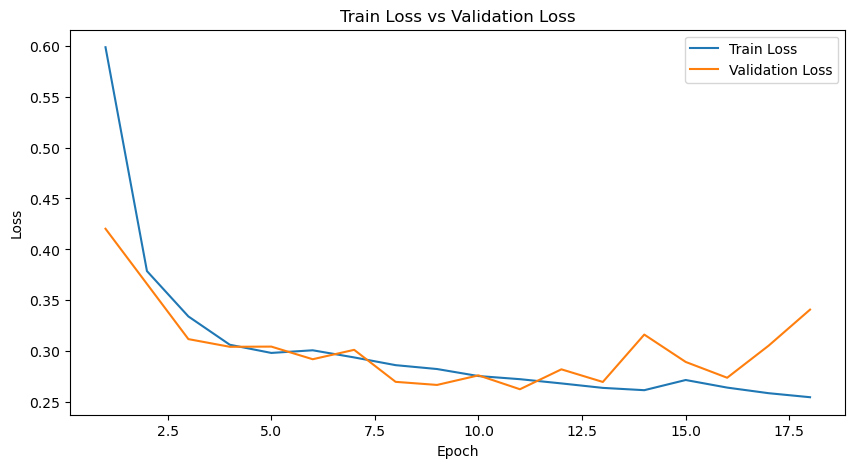

In [13]:
plot_losses(epochs_used, train_losses, val_losses)

In [14]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': -early_stopping.best_score,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_3_bigger_basic_ciou.pt"))